## README ❗

Set a manual_seed for reproducibility.

References:

- See [Reproducibility](https://pytorch.org/docs/stable/notes/randomness.html)






### TO-DO ✅


#### FIX 🧯


Quando viene sollevata un'eccezione in DataPreprocessor.__getitem __ viene restituito uno stack di immagini vuote. Aggiungere il relativo ID ad una lista e in fase di training evitare che queste immagini nere vengano incluse nel batch. Magari sostituendo a queste una delle immagini valide presenti nello stesso batch.


## Environment setup 🏛


In [1]:
! pip install python-dotenv
! pip install monai
! pip install shutil
! pip install mlflow --quiet
! pip install pyngrok --quiet
! pip install torchmetrics

import os
import sys
from google.colab import drive

from mlflow.models.signature import infer_signature
import mlflow
import mlflow.pytorch
from pyngrok import ngrok

import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import tarfile
import nibabel as nib
import glob
import random
import shutil
import time
from distutils.dir_util import copy_tree

from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import SequentialSampler
from torchvision import utils

from monai.networks.nets import AutoEncoder
from monai.losses import DiceCELoss, DiceFocalLoss, DiceLoss, FocalLoss

drive.mount('/content/drive/')

#torch.use_deterministic_algorithms(True, warn_only=True)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 12.6 MB/s eta 0:00:00
Mounted at /content/drive/
Using cuda devic

In [2]:
%%bash

if [ ! -f '/content/drive/MyDrive/Lorusso/BraTS/.env' ]; then
    echo "Creating .env file..."
    echo "INPUT_DATA_DIR='/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats'" > '/content/drive/MyDrive/Lorusso/BraTS/.env'
    echo "PROCESSED_DATA_DIR='/content/drive/MyDrive/Lorusso/BraTS/data/processed'" >> '/content/drive/MyDrive/Lorusso/BraTS/.env'
fi

In [3]:
%%bash

if [ ! -f '/content/drive/MyDrive/Lorusso/BraTS/data/raw/BraTS2021_Training_Data.tar'  ]; then
    echo "Downloading BraTS dataset at /content/drive/MyDrive/Lorusso/BraTS/data/raw ..."
    mkdir /root/.kaggle/
    cp '/content/drive/MyDrive/Lorusso/kaggle.json' /root/.kaggle
    chmod 600 '/root/.kaggle/kaggle.json'
    cd '/content/drive/MyDrive/Lorusso/BraTS/data/raw' && kaggle datasets download -d dschettler8845/brats-2021-task1
    ls '/content/drive/MyDrive/Lorusso/BraTS/data/raw'
    unzip '/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats-2021-task1.zip' -d '/content/drive/MyDrive/Lorusso/BraTS/data/raw/'
    rm -r '/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats-2021-task1.zip'
fi

In [4]:
%%bash
path='/content/drive/MyDrive/Lorusso/BraTS/data/raw/brats'
dst='/content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled/'

if [ ! -d '/content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled' ]; then

    mkdir '/content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled'

    rm -r /content/drive/MyDrive/Lorusso/BraTS/data/interim/train
    rm -r /content/drive/MyDrive/Lorusso/BraTS/data/interim/test
    rm -r /content/drive/MyDrive/Lorusso/BraTS/data/interim/val

    for el in $(ls $path | head -n 50);
        do
            echo "$path/$el -> $dst"
            cp -R "$path/$el" $dst
        done
fi


## MLFlow server

In [5]:
mlflow.set_tracking_uri('file:///content/drive/MyDrive/Lorusso/BraTS/mlruns')

# Terminate open tunnels if exist
ngrok.kill()
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2Yliuv8VnNyKNcljxgEv6NpZgz8_6ZDBYmEcebUeoX93eGJAE"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --backend-store-uri file:///content/drive/MyDrive/Lorusso/BraTS/mlruns --port 5000 & ")


MLflow Tracking UI: https://1432-34-41-213-52.ngrok-free.app


## Utils 🛠

In [6]:
def untar_brats(tar_path, extract_path):
    tar = tarfile.open(tar_path)
    tar.extractall(extract_path)
    tar.close()



def plot_reconstruction(im_orig, im_rec, ax:int = 0, slice_index:int = 100):

    f, ax_array = plt.subplots(1,2, figsize=(10,10))
    ax_array[0].imshow(np.take(im_orig, indices = slice_index, axis = ax), cmap='gray')
    ax_array[1].imshow(np.take( im_rec , indices=slice_index, axis = ax), cmap='gray')

def plot_brain_sections(images,ax = 1,slice_index = 90):

    """
    """

    d1,d2,d3 = np.shape(images[1])
    dims = [d1,d2,d3]
    dims.pop(ax)
    color_segmentation = np.zeros((dims[0],dims[1],3))

    gray_segmentation = np.take(images[1],slice_index,axis = ax)
    color_segmentation[gray_segmentation == 1] = [255,0,0] # Red (necrotic tumor core)
    color_segmentation[gray_segmentation == 2] = [0,255,0] # Green (peritumoral edematous/invaded tissue)
    color_segmentation[gray_segmentation == 4] = [0,0,255] # Blue (enhancing tumor)

    t1 = images[0][0]
    flair = images[0][1]
    t2 = images[0][2]
    t1ce = images[0][3]

    image = t1+t2+flair+t1ce

    plt.figure(figsize=(15,15))
    plt.subplot(1,4,1)
    plt.imshow(np.take(image,slice_index,axis = 0),cmap='gray')

    plt.subplot(1,4,2)
    plt.imshow(np.take(image,slice_index,axis = 1),cmap='gray')

    plt.subplot(1,4,3)
    plt.imshow(np.take(image,slice_index,axis = 2),cmap='gray')

    plt.subplot(1,4,4)
    plt.imshow(color_segmentation,cmap='gray')
    plt.xlabel('Segmentation')


def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.cpu().permute((1, 2, 0)))





## Dataset class  💾


In [7]:
'''
Preprocessing script to convert from data provided by BraTS to data used by our model. Should be the first thing you run.
Fulfills the following four functions:
1. Normalize and standardize each image of each MRI modality
2. Combine multiple MRI modalitities into one image array
3. Swap labels from BraTS order (0,2,1,4) to more intuitive order (0,1,2,3)
4. Convert image into a graph
    Using Simple Linear Iterative Clustering algorithm
    Parameters passed on command line

If no labels are present (e.g. at test time, in deployment) can also build graph without labels.

Saves the following in the specified output directory for each sample
MRI_ID/
    _input.nii.gz (processed and combined modalities for a sample as nifti file)
    _label.nii.gz
    _nxgraph.json (networkx graph containing both graph topography and features and labels for each node)
    _supervoxels.nii.gz (supervoxel partitioning produced by SLIC)
    _crop.npy (optionally the crop of the processed data relative to the original data) (crops out empty image planes)
'''


class DataPreprocessor(Dataset):
  def __init__(self, dotenv_path = "/content/drive/MyDrive/Lorusso/BraTS/.env", transform = True, INPUT_PATH = None):

    load_dotenv(dotenv_path)
    # Data mean and variance
    data_stats = ([0.4645, 0.6625, 0.4064, 0.3648], [0.1593, 0.1703, 0.1216, 0.1627])

    if(INPUT_PATH is not None and os.path.exists(INPUT_PATH)):
        self.data_dir = INPUT_PATH
    else:
        self.data_dir = os.getenv('INPUT_DATA_DIR')
    self.output_dir = os.getenv('PROCESSED_DATA_DIR')
    self.mri_prefix = 'BraTS2021'
    self.modality_extensions = ["_flair.nii.gz", "_t1.nii.gz", "_t1ce.nii.gz", "_t2.nii.gz"]
    self.label_extension = "_seg.nii.gz"
    self.include_labels = self.label_extension is not None
    self.all_ids, self.id_to_fp = self.get_all_mris_in_dataset()
    self.LABEL_MAP = {4: 3, 2: 1, 1: 2}
    self.dataset_mean = np.array(data_stats[0], dtype=np.float32)
    self.dataset_std = np.array(data_stats[1], dtype=np.float32)
    self.transform = transform if isinstance(transform, bool) else True


  def __len__(self):
    return len(self.all_ids)


  def __getitem__(self,idx):
    images = []
    # Load the image corresponding to idx
    try:
      fp = [self.id_to_fp[k] for k in self.all_ids if k.split('_')[-1] == idx][0]
      bn = os.path.basename(os.path.split(fp)[0])
      images.append([nib.load(os.path.join(fp, bn + level)).get_fdata(dtype=np.float32).T
                     for level in self.modality_extensions])
      labels = nib.load(os.path.join(fp, bn + self.label_extension)).get_fdata(dtype=np.float32).T

      # Convert to numpy array otherwise you'll experience RAM leak
      images = np.asarray(images[0])
      imstack = np.stack(np.array(images, dtype=np.float32), axis = 0)
      imstack, labels = self.padding(imstack, labels)

      if (self.transform):
          imstack,labels = self.get_standardized_image(imstack, labels)

    except Exception as e:
      print(f"Exception thrown in class {self.__class__.__name__ }, method __getitem__")
      print(e)
      imstack = np.zeros([4,240,240,240],dtype=np.float32)
      labels = np.zeros([240, 240, 240])

    return np.array(imstack), labels


  def get_all_mris_in_dataset(self):
    mri_folders = glob.glob(f"{self.data_dir}**/{self.mri_prefix}*/",
                            recursive=True)
    mri_folders = self.remove_incomplete_mris(mri_folders)
    scan_dic = {os.path.split(fp)[0].split("/")[-1]: fp for fp in mri_folders}
    if(len(mri_folders) == 0):
        print("No MRI found at " + self.data_dir)
    return list(scan_dic.keys()), scan_dic


  def remove_incomplete_mris(self, mri_folders):
    # if there are any you want to ignore just add them to this list
    removed_mris = []
    return [fp for fp in mri_folders if fp.split("/")[-2] not in removed_mris]


  def split_dataset(self, ratio = (.6,.2,.2),seed = 42):

    random.seed(seed)
    if(np.sum(ratio) != 1 or ratio is None):
      print("Error: ratio does not sum up to one.\nSwitching to default (.6,.2,.2))")
      ratio = (.6,.2,.2)

    train_length = int(len(self.all_ids)*ratio[0])
    val_length = int(len(self.all_ids)*ratio[1])
    test_length = int(len(self.all_ids)*ratio[2])
    pos = random.sample(range(0,len(self.all_ids)), len(self.all_ids))

    split_dict = {
        'train': [self.all_ids[i] for i in pos[:train_length]],
        'val': [self.all_ids[i] for i in pos[train_length :train_length + val_length]],
        'test': [self.all_ids[i] for i in pos[train_length + val_length:]]
    }

    for k in split_dict.keys():
      parent = '/'.join(self.data_dir.split('/')[:-1])
      dst = os.path.join(parent,k)

      try:
        # create train,val,test dirs
        if(not os.path.exists(dst)):
          os.mkdir(dst)

        # copy splitted data inside folders
        for id in split_dict[k]:
          if(not os.path.exists(os.path.join(dst,id))):
             os.mkdir(os.path.join(dst,id))
          copy_tree(self.id_to_fp[id],os.path.join(dst,id))

      except Exception as e:
        print(f"Exception thrown in class {self.__class__.__name__ }, method split_dataset")
        print(e)


  def padding(self,image, labels):
    n_channels = np.shape(image)[0]
    max_val = max(np.shape(image))
    pad_list = np.zeros([n_channels,max_val,max_val,max_val],dtype=np.float32)

    for channel in range(0, n_channels): # pad every channel
        pad_list[channel] = np.pad(image[channel],[(42,43),(0,0),(0,0)],'constant')
    labels = np.pad(labels, [(42,43),(0,0),(0,0)],'constant')

    return pad_list, labels


  def get_standardized_image(self, image_data, label_data):

    standardized_labels = self.swap_labels_from_brats(label_data)
    #standardized_data = self.standardize_img(
    #    image_data, self.dataset_mean, self.dataset_std)
    #normalized_data = self.standardize_img(image_data)
    normalized_data = self.normalize_img(image_data)
    return normalized_data, standardized_labels


  def normalize_img(self, img_array):
    new_image = np.zeros(img_array.shape, dtype=np.float32)
    n_channel = img_array.shape[0] # channel-first images

    for channel in range(0, n_channel): # normalize every channel

        maxval, minval= np.max(img_array[channel]), np.min(img_array[channel])
        new_image[channel] = (img_array[channel] - minval)/(maxval-minval)

    return new_image




  def normalize_img_quantile(self, img_array):
    quantile = np.quantile(img_array, 0.995, axis = (0,1,2,3) )
    #print(quantile)
    return img_array/quantile

    #return img_array



  def standardize_img(self,img_array):
    img_array = img_array.T # Align shapes
    centered = img_array-self.dataset_mean
    standardized = centered/self.dataset_std
    return standardized.T


  def swap_labels_from_brats(self,label_data):
    uniques = np.unique(label_data)
    for u in uniques:
        if u not in [0, 1, 2, 4]:
            raise RuntimeError('unexpected label')
    new_label_data = np.zeros_like(label_data, dtype=np.int16)
    new_label_data[label_data == 4] = self.LABEL_MAP[4]
    new_label_data[label_data == 2] = self.LABEL_MAP[2]
    new_label_data[label_data == 1] = self.LABEL_MAP[1]
    return new_label_data


  def swap_labels_to_brats(self,label_data):
    uniques = np.unique(label_data)
    for u in uniques:
        if u not in [0, 1, 2, 3]:
            raise RuntimeError('unexpected label')
    new_label_data = np.zeros_like(label_data, dtype=np.int16)
    new_label_data[label_data == self.LABEL_MAP[4]] = 4
    new_label_data[label_data == self.LABEL_MAP[2]] = 2
    new_label_data[label_data == self.LABEL_MAP[1]] = 1
    return new_label_data




class SeqSampler(SequentialSampler):
  """Samples elements sequentially, always in the same order.

    Args:
        data_source (Dataset): dataset to sample from
  """
  def __init__(self, data_source:Dataset):
    self.data_source = data_source
    self.indexDict = [id.split('_')[1] for id in data_source.all_ids]
  def __iter__(self):
    return iter(self.indexDict)
  def __len__(self):
    return len(self.indexDict)


## Models 📪


In [8]:
class Autoencoder3D(nn.Module):
    def __init__(self):
        super(Autoencoder3D, self).__init__()
        # Encoder
        self.activation = nn.ReLU()
        #self.activation = nn.LogSigmoid()# nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.conv1 = nn.Conv3d(4, 8, 3)
        self.conv2 = nn.Conv3d(8, 32, 3)
        self.conv3 = nn.Conv3d(64, 256, 2)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.enc_linear = nn.Linear(381216, 512)

        # Decoder
        self.deconv1 = nn.ConvTranspose3d(256, 64, 2)
        self.deconv2 = nn.ConvTranspose3d(32, 8, 3)
        self.deconv3 = nn.ConvTranspose3d(8, 4, 3)
        self.unpool1 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool3 = nn.MaxUnpool3d(kernel_size=2, stride=2)

        self.dec_linear = nn.Linear(512, 381216)

    def encode(self, x, return_partials=True):
        # Encoder
        x = self.conv1(x)
        x = self.activation(x)
        up3out_shape = x.shape
        x, indices1 = self.pool1(x)

        x = self.conv2(x)
        x = self.activation(x)
        up2out_shape = x.shape
        x, indices2 = self.pool2(x)

        #x = self.conv3(x)
        #x = self.activation(x)
        #up1out_shape = x.shape
        #x, indices3 = self.pool3(x)



        #print(x.shape)
        #x = x.view((x.size(0), -1))
        #print(x.shape)
        #x = self.enc_linear(x)

        # required for unpool
        pool_par = {
            "P1": [indices1, up3out_shape],
            "P2": [indices2, up2out_shape],
            #"P3": [indices3, up1out_shape]
                   }

        if return_partials:
            return x, pool_par
        else:
            return x

    def decode(self, x, pool_par):
        #x = self.dec_linear(x)
        #x = x.view((x.size(0), 96, 11, 19, 19))

        #x = self.unpool1(x, output_size=pool_par["P3"][1], indices=pool_par["P3"][0])
        ##print(x.shape)
        #x = self.deconv1(x)
        #x = self.activation(x)

        x = self.unpool2(x, output_size=pool_par["P2"][1], indices=pool_par["P2"][0])
        x = self.deconv2(x)
        x = self.activation(x)
#
        x = self.unpool3(x, output_size=pool_par["P1"][1], indices=pool_par["P1"][0])
        x = self.deconv3(x)
        x = self.sigmoid(x)
        return x

    def forward(self, x):
        self.feature, pool_par = self.encode(x)
        out = self.decode(self.feature, pool_par)
        return out

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, slope = 0.2):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(4, 16, kernel_size=(3,3,3), stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(16),
            nn.MaxPool3d(kernel_size=2, stride=2),

            nn.Conv3d(16, 64 , kernel_size=(3,3,3), stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(64),
            nn.MaxPool3d(kernel_size=2, stride=2),

        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(64, 16, kernel_size=(3,3,3), stride=2, padding=1,output_padding=1, bias=False),

            nn.ConvTranspose3d(16, 4, kernel_size=(3,3,3), stride=2, padding=1, output_padding=1, bias=False),
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


## Model Wrapper 📨


In [24]:
class ModelWrapper():
  """
  Allows train, evaluation, prediction and I/O operations on generic PyTorch models
  The model is saved at every epoch.
  """

  def __init__(self, model: nn.Module, optimizer: nn.Module, loss_fn: nn.Module,
               num_epochs: int, supervised: bool = True, LOAD_MODEL: bool = False,
               model_path: str  = '/content/drive/MyDrive/Lorusso/models'):

    self.device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    self.model = model
    self.model = self.model.to(self.device)
    self.model = self.model.to(torch.float)
    self.num_epochs = num_epochs
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.model_path = model_path
    self.save_path = self.model_path + '/' + self.model.__class__.__name__ + '/model.pt'

    self.supervised = supervised
    self.training_loss = []
    self.validation_loss = []
    self.elapsed_epochs = 0
    self.elapsed_seconds = 0

    if(LOAD_MODEL):
      self.load_checkpoint()

    # Create directory for model loading
    try:
      if(not os.path.exists(self.model_path + '/' + self.model.__class__.__name__)):
        os.mkdir(self.model_path + '/' + self.model.__class__.__name__)
    except Exception as e:
      print(f"Exception thrown in class {self.model.__class__.__name__ }, method __init__")
      print(e)
      print('\n')


  def log_checkpoint(self, info: dict):
    mlflow.pytorch.log_state_dict(info, artifact_path='checkpoint')
    #torch.save(info, self.save_path)

  def load_checkpoint(self):
    """
    Loads the last checkpoint for the given model
    """
    try:
        run_id = mlflow.search_runs(experiment_names=['BraTS_'+type(self.model).__name__],
                                    order_by=["start_time DESC"]).iloc[0].run_id

        checkpoint = mlflow.pytorch.load_state_dict('runs:/'+run_id+'/checkpoint', map_location=torch.device(self.device))
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.elapsed_epochs = len(checkpoint['training_loss'])
        self.training_loss = checkpoint['training_loss']
        self.validation_loss = checkpoint['validation_loss']
        self.elapsed_seconds = checkpoint['elapsed_seconds']

        # Track metrics in the current run
        mlflow.start_run()
        for i in range(len(training_loss)):
            mlflow.log_metric('train_loss', training_loss[i], step=i)

        for i in range(len(validation_loss)):
            mlflow.log_metric('val_loss', validation_loss[i], step=i)

        #checkpoint = torch.load(self.save_path, map_location=torch.device(self.device))
        #self.model.load_state_dict(checkpoint['model_state_dict'])
        #self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #self.elapsed_epochs = checkpoint['epochs']
        #self.training_loss = checkpoint['training_loss']
        #self.validation_loss = checkpoint['validation_loss']
        #self.elapsed_seconds = checkpoint['elapsed_seconds']
    except Exception as e:
        print(f"Exception thrown in class {self.model.__class__.__name__ }, method load_checkpoint")
        print(e)
        print('\n')
        if(mlflow.active_run):
            mlflow.end_run()


  def train(self, train_loader, val_loader = None):

    try:
        # Set MLFlow experiment
        mlflow.set_experiment('BraTS_'+self.model.__class__.__name__)

        # Start a new run if the model wasn't loaded
        if(not mlflow.active_run()):
            mlflow.start_run()

        param_dict = {
            'batch_size':train_loader.batch_size,
            'loss_fn':self.loss_fn.__class__.__name__,
            'optimizer':self.optimizer.__class__.__name__,
            'learning_rate':self.optimizer.state_dict()['param_groups'][0]['lr'],
            'weight_decay':self.optimizer.state_dict()['param_groups'][0]['weight_decay'],
        }
        mlflow.log_params(param_dict)

        training_loss = self.training_loss
        validation_loss = self.validation_loss

        self.tot_epochs = self.elapsed_epochs + self.num_epochs+1
        self.tot_time = time.time()

        # Train
        for epoch in range(self.elapsed_epochs+1, self.tot_epochs):
            start = time.time() # track time

          # Evaluate first if loaded model missed the evaluation during an epoch
            if(len(training_loss) > len(validation_loss)):
                if(val_loader is not None):

                  ## COMPLETE EVALUATION OF PREVIOUS EPOCH ##
                  # NB: epoch = epoch - 1
                    val_batch_loss = self.__eval(val_loader, (epoch-1) )
                    validation_loss.append(np.array(val_batch_loss).mean())

                    # Log metric
                    mlflow.log_metric('val_loss',validation_loss[-1], step=epoch-1)

                    print(f"Epoch: {epoch-1}/{self.tot_epochs-1}, Validation Loss: {validation_loss[-1]:.4f}, Elapsed time: {time.time() - start:.0f} sec ")

                  # Update training time
                    epoch_time = int(time.time() - self.tot_time) + self.elapsed_seconds

                  #Create checkpoint
                    val_dict = {
                              'model_state_dict': self.model.state_dict(),
                              'optimizer_state_dict': self.optimizer.state_dict(),
                              'training_loss': training_loss,
                              'validation_loss': validation_loss,
                              'elapsed_seconds': epoch_time
                              }
                    self.log_checkpoint(val_dict)
                else:
                    # Kind of exception, needed to keep the vectors of the same size
                    validation_loss.append(np.mean(validation_loss))

                    #Log metric
                    mlflow.log_metric('val_loss',validation_loss[-1], step=epoch-1)

            #### TRAIN ######
            train_batch_loss = self.__train(train_loader, epoch)
            training_loss.append(np.array(train_batch_loss).mean())

            # Log metric
            mlflow.log_metric('train_loss',training_loss[-1], step=epoch) # MLFLOW tracking
            print(f"\nEpoch: {epoch}/{self.tot_epochs-1}, Loss: {training_loss[-1]:.4f}, Epoch elapsed time: {time.time() - start:.0f} sec \n")

            #Save model every elapsed epoch
            self.elapsed_epochs = epoch
            epoch_time = int(time.time() - self.tot_time) + self.elapsed_seconds

            train_dict = {
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'training_loss': training_loss,
                      'validation_loss': validation_loss,
                      'elapsed_seconds': epoch_time
                      }
            self.log_checkpoint(train_dict)

            torch.cuda.empty_cache()
            time.sleep(5)
            if(val_loader is not None):

            #### EVALUATE ######
                val_batch_loss = self.__eval(val_loader, epoch)
                validation_loss.append(np.array(val_batch_loss).mean())

                # Log metric
                mlflow.log_metric('val_loss',validation_loss[-1], step=epoch)
                print(f"Epoch: {epoch}/{self.tot_epochs-1}, Validation Loss: {validation_loss[-1]:.4f}, Elapsed time: {time.time() - start:.0f} sec ")

                #Checkpoint
                epoch_time = int(time.time() - self.tot_time) + self.elapsed_seconds
                val_dict = {
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.optimizer.state_dict(),
                          'training_loss': training_loss,
                          'validation_loss': validation_loss,
                          'elapsed_seconds': epoch_time
                          }
                self.log_checkpoint(val_dict)

            print(f"Total training time: {time.time()-self.tot_time:.0f} sec")

        # Log model --> end run
        mlflow.pytorch.log_model(self.model, artifact_path='model')
        mlflow.end_run()
    except Exception as e:
        print(f"Exception thrown in class {self.model.__class__.__name__ }, method train:")
        print(e)
        print('\n')
        mlflow.end_run()


    return training_loss, validation_loss



  def __train(self, train_loader: DataLoader, epoch:int):

    """ Train for an epoch """

    self.model.train()
    train_batch_loss = []
    train_steps = int(len(train_loader.dataset.all_ids)/train_loader.batch_size)

    for i, (data,labels) in enumerate(train_loader):

      torch.cuda.empty_cache()
      self.optimizer.zero_grad()

      if self.device == 'cuda':
        data = data.type(torch.cuda.FloatTensor)
      else:
        data = data.type(torch.FloatTensor)

      data = data.to(self.device)

      outputs = self.model(data)

      if(self.supervised):
        loss = self.loss_fn(outputs,labels)
      else:
        loss = self.loss_fn(outputs, data)

      loss.backward()
      self.optimizer.step()
      train_batch_loss.append(loss.detach().item())

      out = f"Epoch: {epoch}/{self.tot_epochs-1}, Step: {i+1}/{train_steps}, Loss: {loss.item():.4f}, Elapsed time: {time.time() - self.tot_time:.0f} sec "
      sys.stdout.write("\r" + out)
      sys.stdout.flush()

    return train_batch_loss


  def __eval(self, val_loader: DataLoader, epoch:int):

    """ Evaluate for an epoch """

    val_steps = int(len(val_loader.dataset.all_ids)/val_loader.batch_size)
    self.model.eval()
    val_batch_loss = []

    with torch.no_grad():
      for i, (data,labels) in enumerate(val_loader):

        torch.cuda.empty_cache()
        self.optimizer.zero_grad()

        if self.device == 'cuda':
          data = data.type(torch.cuda.FloatTensor)
        else:
          data = data.type(torch.FloatTensor)

        data = data.to(self.device)
        outputs = self.model(data)

        if(self.supervised):
            val_loss = self.loss_fn(outputs, labels)
        else:
            val_loss = self.loss_fn(outputs, data)

        val_batch_loss.append(val_loss.detach().item())

        out = f"Epoch: {epoch}/{self.tot_epochs-1}, Validation Step: {i+1}/{val_steps}, Validation Loss: {val_loss.item():.4f}, Elapsed time: {time.time() - self.tot_time:.0f} sec "
        sys.stdout.write("\r" + out)
        sys.stdout.flush()

    return val_batch_loss





  def predict_batch(self, data_loader):

    output = []
    self.model = self.model.to(self.device)
    self.model.eval()
    with torch.no_grad():
        try:
          for i, batch in enumerate(data_loader):
            torch.cuda.empty_cache()

            if(len(batch) == 1):
              data = batch
            else:
              data,label = batch

            if self.device == 'cuda':
              data = data.type(torch.cuda.FloatTensor)
            else:
              data = data.type(torch.FloatTensor)

            data.to(self.device)

            out = self.model(data)
            out = out.cpu().detach().numpy()
            output.append(out)

        except Exception as e:
            print(f"Exception thrown in class {self.model.__class__.__name__ }, method predict_batch:")
            print(e)
            print('\n')

    return np.array(output)


  def predict(self, data):

    if device == 'cuda':
      data = data.type(torch.cuda.FloatTensor)
    else:
      data = data.type(torch.FloatTensor)

    self.model.eval()
    with torch.no_grad():
        data.to(device)
        output = self.model(data)
    return output






## Loss 🕳

In [11]:
class Loss(nn.Module):
    def __init__(self, focal):
        super(Loss, self).__init__()
        if focal:
            self.loss_fn = DiceFocalLoss(
                include_background=False, softmax=True, to_onehot_y=True, batch=True, gamma=2.0
            )
        else:
            self.loss_fn = DiceCELoss(include_background=False, softmax=True, to_onehot_y=True, batch=True)

    def forward(self, y_pred, y_true):
        return self.loss_fn(y_pred, y_true)


class LossBraTS(nn.Module):
    def __init__(self, focal):
        super(LossBraTS, self).__init__()
        self.dice = DiceLoss(sigmoid=True, batch=True)
        self.ce = FocalLoss(gamma=2.0, to_onehot_y=False) if focal else nn.BCEWithLogitsLoss()

    def _loss(self, p, y):
        return self.dice(p, y) + self.ce(p, y.float())

    def forward(self, p, y):
        y_wt, y_tc, y_et = y > 0, ((y == 1) + (y == 3)) > 0, y == 3
        p_wt, p_tc, p_et = p[:, 0].unsqueeze(1), p[:, 1].unsqueeze(1), p[:, 2].unsqueeze(1)
        l_wt, l_tc, l_et = self._loss(p_wt, y_wt), self._loss(p_tc, y_tc), self._loss(p_et, y_et)
        return l_wt + l_tc + l_et

## Build dataset 🏗

In [12]:
dotenv_path = "/content/drive/MyDrive/Lorusso/BraTS/.env"
load_dotenv(dotenv_path)


INPUT_PATH = os.getenv("INPUT_DATA_DIR")
PROCESSED_PATH = os.getenv('PROCESSED_DATA_DIR')
INPUT_PATH_PARENT = '/'.join(INPUT_PATH.split('/')[:-1])

TRAIN_PATH = os.path.join(INPUT_PATH_PARENT,'train')
VAL_PATH = os.path.join(INPUT_PATH_PARENT,'val')
TEST_PATH = os.path.join(INPUT_PATH_PARENT,'test')

TAR_PATH = os.path.join(INPUT_PATH_PARENT,'BraTS2021_Training_Data.tar')
BUILD_DATASET = False

if(BUILD_DATASET):
  untar_brats(tar_path = '/content/drive/MyDrive/Lorusso/BraTS/data/raw/BraTS2021_Training_Data.tar', extract_path = INPUT_PATH )
  dataset = DataPreprocessor()
  dataset.split_dataset()

#dataset = DataPreprocessor()
#train_loader = DataLoader(dataset, sampler = SeqSampler(dataset), batch_size = 1, num_workers = 0)
#images, labels= next(iter(train_loader))
#plot_brain_sections([images[0], labels[0]])
#del images, labels, train_loader, dataset

## Train and predict ⌛

In [25]:
TRAIN_MODEL = False
LOAD_MODEL = True

torch.cuda.empty_cache()
time.sleep(10)
if(TRAIN_MODEL or LOAD_MODEL):
  num_workers = 1
  batch_size = 1
  num_epochs = 1
  lr = 0.005
  supervised = False

  # MONAI AUTOENCODER
  model = AutoEncoder(
         spatial_dims=3,
         kernel_size = 3,
         up_kernel_size = 3,
         in_channels=4,
         out_channels=4,
         channels=(5,),
         strides=(2,),
         inter_channels=(8, 16, 32),
         inter_dilations=(1, 2, 4),
         num_inter_units=2
     )

  optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-10)
  loss_fn = nn.MSELoss() #SSIMLoss(spatial_dims=3)

  wrapper = ModelWrapper(model = model,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            supervised = supervised,
                            num_epochs = num_epochs,
                            LOAD_MODEL = LOAD_MODEL
                        )

  dataset = DataPreprocessor(INPUT_PATH = INPUT_PATH)

  # Split dataset if it's not
  if(not os.path.exists(TRAIN_PATH)):
    dataset.split_dataset()


  train_dataset = DataPreprocessor(INPUT_PATH = TRAIN_PATH)
  val_dataset = DataPreprocessor(INPUT_PATH = VAL_PATH)
  test_dataset = DataPreprocessor(INPUT_PATH = TEST_PATH)

  train_loader = DataLoader(dataset = train_dataset,
                           sampler = SeqSampler(train_dataset),
                           batch_size = batch_size,
                           num_workers = num_workers)

  val_loader = DataLoader(dataset = val_dataset,
                           sampler = SeqSampler(val_dataset),
                           batch_size = batch_size,
                           num_workers = num_workers)

  test_loader = DataLoader(dataset = test_dataset,
                           sampler = SeqSampler(test_dataset),
                           batch_size = batch_size,
                           num_workers = num_workers)


  print('Elapsed epochs: ' + str(wrapper.elapsed_epochs))

if(TRAIN_MODEL):
      training_loss, validation_loss = wrapper.train(train_loader = train_loader, val_loader = val_loader )
      torch.cuda.empty_cache()

2023/12/07 18:20:34 WARNING mlflow.tracking.fluent: Cannot retrieve experiment by name BraTS_AutoEncoder


Exception thrown in class AutoEncoder, method load_checkpoint
single positional indexer is out-of-bounds


Elapsed epochs: 0


In [14]:
if(TRAIN_MODEL or LOAD_MODEL):
  xx = range(1,wrapper.elapsed_epochs+1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(xx, wrapper.training_loss, '-o', label = 'Train')
  plt.plot(xx, wrapper.validation_loss,'-o', label = 'Val')
  plt.legend(loc='lower left')

In [15]:
if(TRAIN_MODEL or LOAD_MODEL):

  slice_index = 150
  ax = 0

  im_test, lab = next(iter(test_loader))
  output = wrapper.predict(data = im_test)
  out = output[0]
  out_numpy = out.cpu().detach().numpy()
  im_test_numpy = im_test.cpu().detach().numpy()

  plot_reconstruction(im_orig = np.sum(im_test_numpy[0], axis=0), im_rec = np.sum(out_numpy, axis = 0), ax = ax, slice_index = slice_index)
  plot_brain_sections([im_test[0], lab[0]], ax = ax, slice_index = slice_index)

In [16]:
if(TRAIN_MODEL or LOAD_MODEL):
  ker = wrapper.model.decode[0][0][0].weight.detach().clone()
  print(ker.size())
  #
  visTensor(ker[0], allkernels=True)

  ker = wrapper.model.decode[0][0][0].weight.detach().clone()
  print(ker.size())
  #
  visTensor(torch.sum(ker, dim=(0)), allkernels=True)

  kk = torch.sum(ker, dim= 0)
  kk = torch.sum(kk, dim = 0)
  plt.imshow(kk[0,:,:].cpu().detach().numpy())

# TESTING SECTION 🚧

In [17]:
#! rm -r /content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled
#! rm -r /content/drive/MyDrive/Lorusso/BraTS/data/interim/train
#! rm -r /content/drive/MyDrive/Lorusso/BraTS/data/interim/test
#! rm -r /content/drive/MyDrive/Lorusso/BraTS/data/interim/val

In [18]:

TEST_MODE = False

torch.cuda.empty_cache()
if(TEST_MODE):

  INPUT_PATH = '/content/drive/MyDrive/Lorusso/BraTS/data/interim/sampled'
  INPUT_PATH_PARENT = '/'.join(INPUT_PATH.split('/')[:-1])
  TRAIN_PATH = os.path.join(INPUT_PATH_PARENT,'train')
  VAL_PATH = os.path.join(INPUT_PATH_PARENT,'val')
  TEST_PATH = os.path.join(INPUT_PATH_PARENT,'test')

  TRAIN_MODEL = False
  LOAD_MODEL = True # resume training

  num_workers = 1
  batch_size = 1
  num_epochs = 1
  lr = 0.01
  supervised = False

  # MONAI AUTOENCODER
  model = AutoEncoder(
         spatial_dims=3,
         kernel_size = 3,
         up_kernel_size = 3,
         in_channels=4,
         out_channels=4,
         channels=(5,),
         strides=(2,),
         inter_channels=(8, 16, 32),
         inter_dilations=(1, 2, 4),
         num_inter_units=2
     )

  optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-10)
  loss_fn = nn.MSELoss() #SSIMLoss(spatial_dims=3)

  wrapper = ModelWrapper(model = model,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            supervised = supervised,
                            num_epochs = num_epochs,
                            LOAD_MODEL = LOAD_MODEL
                        )

  dataset = DataPreprocessor(INPUT_PATH = INPUT_PATH)

  # Split dataset if it's not
  if(not os.path.exists(TRAIN_PATH)):
    dataset.split_dataset()


  train_dataset = DataPreprocessor(INPUT_PATH = TRAIN_PATH)
  val_dataset = DataPreprocessor(INPUT_PATH = VAL_PATH)
  test_dataset = DataPreprocessor(INPUT_PATH = TEST_PATH)

  train_loader = DataLoader(dataset = train_dataset,
                           sampler = SeqSampler(train_dataset),
                           batch_size = batch_size,
                           num_workers = num_workers)

  val_loader = DataLoader(dataset = val_dataset,
                           sampler = SeqSampler(val_dataset),
                           batch_size = batch_size,
                           num_workers = num_workers)

  test_loader = DataLoader(dataset = test_dataset,
                           sampler = SeqSampler(test_dataset),
                           batch_size = batch_size,
                           num_workers = num_workers)


  print('Elapsed epochs: ' + str(wrapper.elapsed_epochs))

  if(TRAIN_MODEL):
      training_loss, validation_loss = wrapper.train(train_loader = train_loader, val_loader = None )
      torch.cuda.empty_cache()


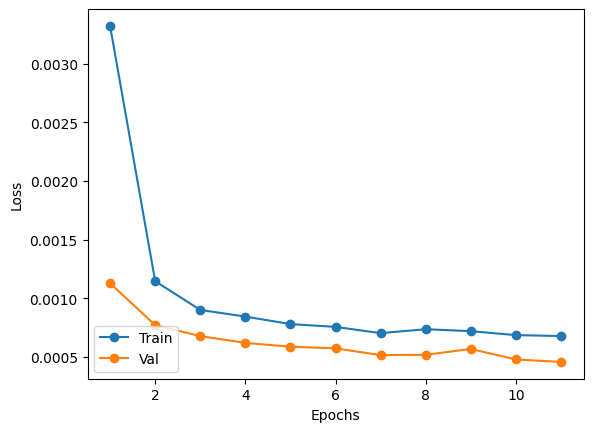

In [29]:
if(TRAIN_MODEL or LOAD_MODEL):
  xx = range(1,wrapper.elapsed_epochs+1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(xx, wrapper.training_loss, '-o', label = 'Train')
  plt.plot(xx, wrapper.validation_loss,'-o', label = 'Val')
  plt.legend(loc='lower left')

In [20]:
if(TRAIN_MODEL or LOAD_MODEL):

  slice_index = 90
  ax = 0

  im_test, lab = next(iter(test_loader))
  output = wrapper.predict(data = im_test)
  out = output[0]
  out_numpy = out.cpu().detach().numpy()
  im_test_numpy = im_test.cpu().detach().numpy()

  plot_reconstruction(im_orig = np.sum(im_test_numpy[0], axis=0), im_rec = np.sum(out_numpy, axis = 0), ax = ax, slice_index = slice_index)
  plot_brain_sections([im_test[0], lab[0]], ax = ax, slice_index = slice_index)

In [21]:
if(TRAIN_MODEL or LOAD_MODEL):
  ker = wrapper.model.decode[0][0][0].weight.detach().clone()
  print(ker.size())
  #
  visTensor(ker[1], allkernels=True)

  ker = wrapper.model.decode[0][0][0].weight.detach().clone()
  print(ker.size())
  #
  visTensor(torch.sum(ker, dim=(0)), allkernels=True)

  kk = torch.sum(ker, dim= 0)
  kk = torch.sum(kk, dim = 0)
  plt.imshow(kk[0,:,:].cpu().detach().numpy())

## MLFlow transitioner

Helps to bring a model saved with pickle to MLFlow

In [37]:
if(False):
    checkpoint = torch.load(wrapper.save_path, map_location=torch.device(wrapper.device))
    wrapper.model.load_state_dict(checkpoint['model_state_dict'])
    wrapper.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    wrapper.elapsed_epochs = checkpoint['epochs']
    wrapper.training_loss = checkpoint['training_loss']
    wrapper.validation_loss = checkpoint['validation_loss']
    wrapper.elapsed_seconds = checkpoint['elapsed_seconds']
    try:
        mlflow.set_experiment('BraTS_'+wrapper.model.__class__.__name__)
        mlflow.start_run()
        param_dict = {
            'batch_size':train_loader.batch_size,
            'optimizer':wrapper.optimizer.__class__.__name__,
            'learning_rate':wrapper.optimizer.state_dict()['param_groups'][0]['lr'],
            'loss_fn':wrapper.loss_fn.__class__.__name__
        }
        mlflow.log_params(param_dict)

        #sample_input,_ = next(iter(train_loader))
        #sample_output = wrapper.predict(sample_input)
        #signature = infer_signature(sample_input.numpy(), sample_output.numpy())
    #
        #print("Model signature:", signature)

        for i in range(len(wrapper.training_loss)):
            mlflow.log_metric('train_loss',wrapper.training_loss[i], step =i+1)
        for i in range(len(wrapper.validation_loss)):
            mlflow.log_metric('val_loss',wrapper.validation_loss[i], step =i+1)

        val_dict = {
              'model_state_dict': wrapper.model.state_dict(),
              'optimizer_state_dict': wrapper.optimizer.state_dict(),
              'elapsed_seconds': wrapper.elapsed_seconds
              }

        mlflow.pytorch.log_state_dict(val_dict,artifact_path="checkpoint")

        mlflow.pytorch.log_model(wrapper.model, artifact_path='model')

        mlflow.end_run()
    except Exception as e:
        print(e)
        mlflow.end_run()

2023/12/07 18:35:37 INFO mlflow.tracking.fluent: Experiment with name 'BraTS_AutoEncoder' does not exist. Creating a new experiment.
2023/12/07 18:35:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.1.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/12/07 18:35:50 WARNING mlflow.utils.requirements_utils: Found torchaudio version (2.1.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchaudio==2.1.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/12/07 18:35:50 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.16.0+cu118) con